In [5]:
import tensorflow as tf
print(tf.__version__)

2.16.1


Data shape: (200000, 784) Labels: (200000,)
X_train: (136000, 28, 28, 1)
X_valid: (24000, 28, 28, 1)
X_test: (40000, 28, 28, 1)


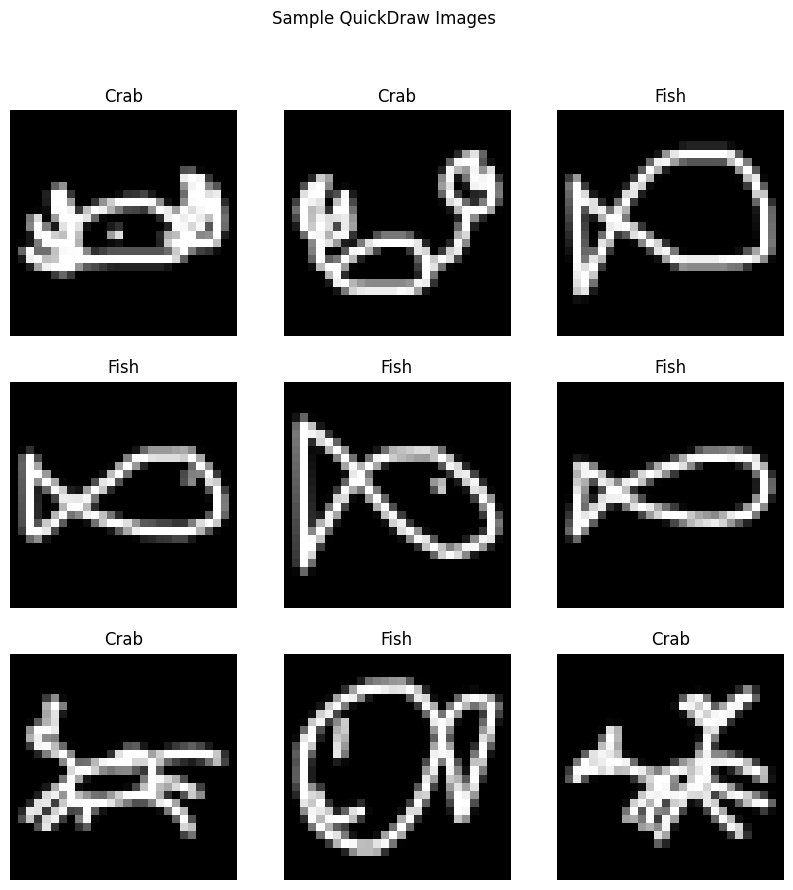

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

Epoch 1/20
4250/4250 - 24s - loss: 0.0918 - accuracy: 0.9635 - val_loss: 0.0582 - val_accuracy: 0.9753 - 24s/epoch - 6ms/step
Epoch 2/20
4250/4250 - 24s - loss: 0.0544 - accuracy: 0.9773 - val_loss: 0.0498 - val_accuracy: 0.9790 - 24s/epoch - 6ms/step
Epoch 3/20
4250/4250 - 24s - loss: 0.0423 - accuracy: 0.9823 - val_loss: 0.0492 - val_accuracy: 0.9807 - 24s/epoch - 6ms/step
Epoch 4/20
4250/4250 - 24s - loss: 0.0331 - accuracy: 0.9866 - val_loss: 0.0657 - val_accuracy: 0.9783 - 24s/epoch - 6ms/step
Epoch 5/20
4250/4250 - 24s - loss: 0.0266 - accuracy: 0.9892 - val_loss: 0.0520 - val_accuracy: 0.9815 - 24s/epoch - 6ms/step
Epoch 6/20
4250/4250 - 24s - loss: 0.0199 - accuracy: 0.9922 - val_loss: 0.0614 - val_accuracy: 0.9810 - 24s/epoch - 6ms/step
Epoch 7/20
4250/4250 - 24s - loss: 0.0151 - accuracy: 0.9940 - val_loss: 0.0654 - val_accuracy: 0.9796 - 24s/epoch - 6ms/step
Epoch 8/20
Restoring model weights from the end of the best epoch: 3.
4250/4250 - 24s - loss: 0.0119 - accuracy: 0.995

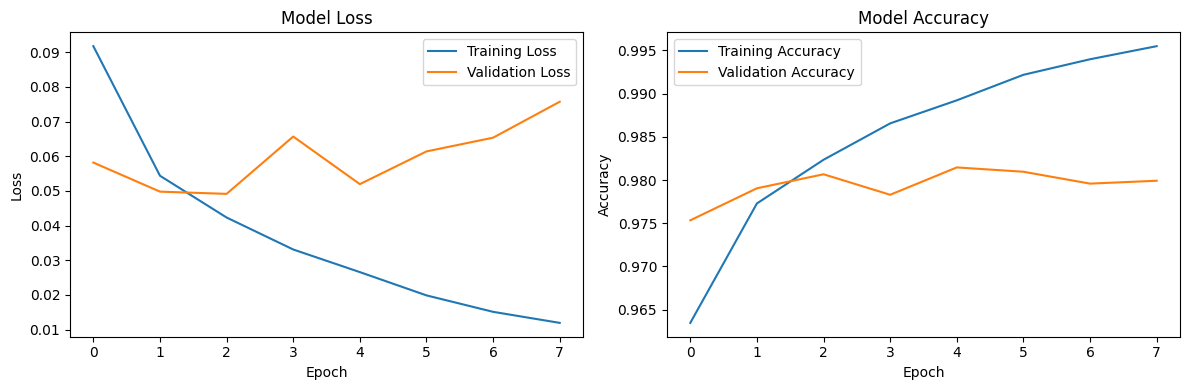

Training history saved as 'training_history.pkl'


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D

# need this for my macbook
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
tf.config.list_physical_devices()
tf.config.list_logical_devices()

# Settings for QuickDraw data
DATA_DIR = "quickdraw_simplified"
CATEGORIES = ["crab", "fish"]
IMG_SIZE = 28
N_PER_CLASS = 100000

# Load data from QuickDraw 
X, y = [], []
for idx, category in enumerate(CATEGORIES):
    file_path = os.path.join(DATA_DIR, f"{category}.npy")
    data = np.load(file_path)
    
    # Limit data per class
    data = data[:N_PER_CLASS]
    
    if data.ndim == 3:
        # Reshape to (n_samples, 784) for flattened images
        data = data.reshape(data.shape[0], -1)
    
    # Normalize to [0, 1]
    data = data / 255.0
    X.append(data)
    y.extend([idx] * len(data))

# Stack all data
X = np.vstack(X)
y = np.array(y)
print("Data shape:", X.shape, "Labels:", y.shape)

# Reshape X back to image format for the model (28, 28, 1)
X = X.reshape(-1, 28, 28, 1)

# Split into train, validation, and test sets
# First split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Then split train+val into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val
)

print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test:", X_test.shape)

# Class names for visualization
class_names = ["Crab", "Fish"]

# Visualize some samples
plt.figure(figsize=(10, 10))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)
    # Remove the channel dimension for display
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.suptitle("Sample QuickDraw Images")
plt.show()

# Build the model
"""
model = Sequential()
model.add(Input(shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(300, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(2, activation="softmax"))  # Changed to 2 classes for binary classification
"""

model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(2, activation="softmax")
])

model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Optional: Add early stopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32,
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stop],
    verbose=2
)

# # Or train without early stopping
# history = model.fit(
#     X_train, y_train, 
#     epochs=20, 
#     batch_size=32,
#     validation_data=(X_valid, y_valid), 
#     verbose=2
# )

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the trained model
# Option 1: Save in Keras format (recommended)
model.save('quickdraw_crab_fish_model.keras')
#print("Model saved as 'quickdraw_crab_fish_model.keras'")

# Option 2: Save in H5 format (legacy)
#model.save('quickdraw_crab_fish_model.h5')

# Option 3: Save in TensorFlow SavedModel format
# model.save('quickdraw_model_folder')

# Option 4: Save only the weights (smaller file)
# model.save_weights('quickdraw_model_weights.weights.h5')

# You can also save the training history for later analysis
import joblib
joblib.dump(history.history, 'training_history.pkl')
print("Training history saved as 'training_history.pkl'")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


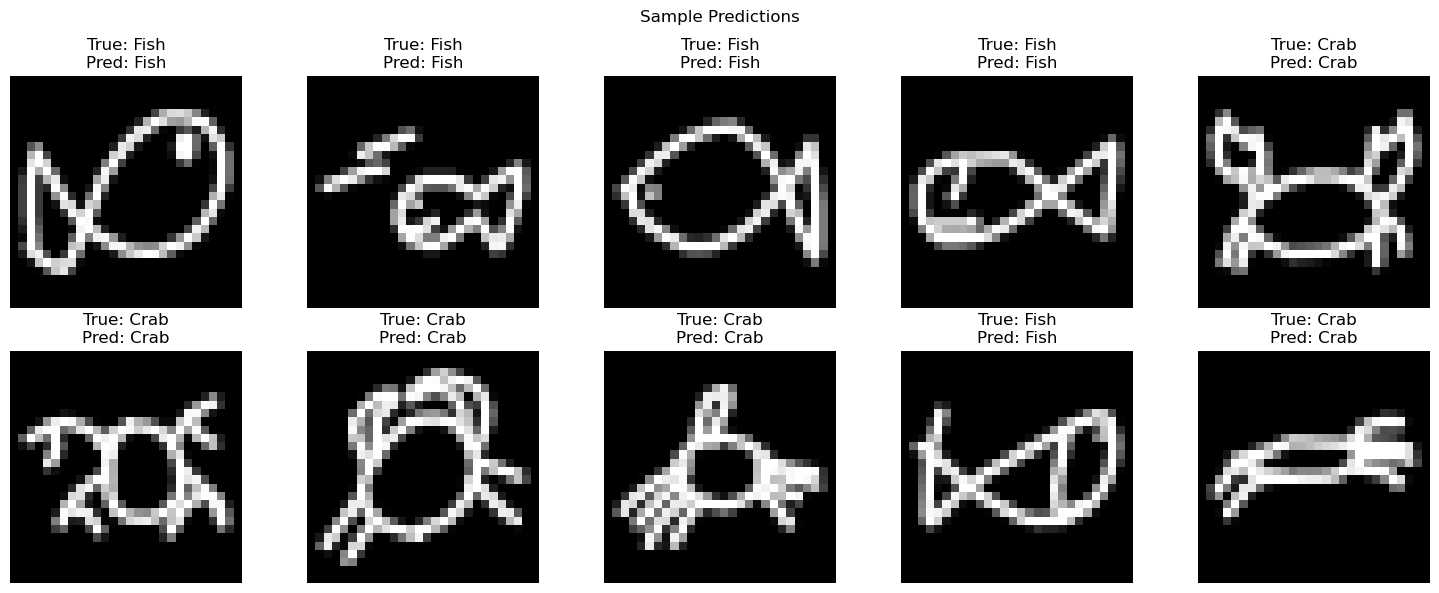

In [7]:
# Make predictions on some test samples
n_samples_to_show = 10
sample_indices = np.random.choice(len(X_test), n_samples_to_show, replace=False)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]

predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)



# Display predictions
plt.figure(figsize=(15, 6))
for i in range(n_samples_to_show):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {class_names[sample_labels[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis('off')
plt.suptitle("Sample Predictions")
plt.tight_layout()
plt.show()